## Convolutional Neural Network



In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1bkcr55sW6BrcgKVPEGTb3vvhpnrklKKq?usp=sharing

Fill in cells below and fit neural networks for solving the binary classification task.

**Requirement**
- Python, Pytorch (Must), and all other necessary libraries
- **Just don't cheat, Thanks!**
- Sample output is to help you understand the task, and get an idea of what you have to do

## Task 1:

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

In [1]:
# Research on how to load google drive files into colab if you are using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchinfo

In [3]:
import torch
import os
import cv2

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from torchinfo import summary

import torch.optim as optim
import matplotlib.pyplot as plt


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
!nvidia-smi

Tue Jul 25 02:42:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
train_paths = []
val_paths = []
test_paths = []

y_train = []
y_val = []
y_test = []

def get_paths(path):
  folder_names = os.listdir(path)
  #print(folder_names)
  for folder_name in folder_names:
    if not (folder_name == '.DS_Store' or folder_name == 'log'):
      folder_path = path + '/' + folder_name
      #print(folder_path)
      level2 = os.listdir(folder_path)
      #print(level2)
      if folder_name == 'train':
        ls = train_paths
        y_ls = y_train
      elif folder_name == 'val':
        ls = val_paths
        y_ls = y_val
      elif folder_name == 'test':
        ls = test_paths
        y_ls = y_test

      #print(folder_name)
      for f in level2:
        level2_path = folder_path + '/' + f
        files_names = os.listdir(level2_path)
        files_names = [level2_path + '/'+ x for x in files_names]
        ls.extend(files_names)
        #print(len(ls))
        if f == 'cats':
          y_ls.extend([0]*len(files_names))
        elif f == 'dogs':
          y_ls.extend([1]*len(files_names))

      ls = None
      y_ls = None

In [ ]:
get_paths('/content/drive/MyDrive/Cats_and_Dogs')
print("train_paths: ", len(train_paths))
print(train_paths)

print("val_paths: ", len(val_paths))
#print(val_paths)

print("test_paths: ", len(test_paths))
#print(test_paths)

print("y_train: ", len(y_train))
#print(y_train)

print("y_val: ", len(y_val))
#print(y_val)

print("y_test: ", len(y_test))
#print(y_test)

In [8]:
def load_images(paths : list) -> list:
  photos = []
  for file_name in paths:
    if file_name != '_DS_Store':
      photo = cv2.imread(file_name)
      photo = cv2.resize(photo, dsize=(100,100))
      photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
      photos.append(photo)

  return np.array(photos)

In [ ]:
X_test = load_images(test_paths)
X_val = load_images(val_paths)
X_train = load_images(train_paths)


In [9]:
y_train = np.array(y_train).reshape((len(y_train),1))
y_val = np.array(y_val).reshape((len(y_val),1))
y_test = np.array(y_test).reshape((len(y_test),1))

In [10]:
y_train= torch.tensor(y_train)
torch.reshape(y_train, (len(y_train),1))

y_test= torch.tensor(y_test)
torch.reshape(y_test, (len(y_test),1))

y_val= torch.tensor(y_val)
torch.reshape(y_val, (len(y_val),1))


tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

## Prepare the data.

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

In [12]:
class Custom_Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
train_dataset = Custom_Dataset(images=X_train, labels=y_train, transform=transform)
val_dataset = Custom_Dataset(images=X_val, labels=y_val, transform=transform)
test_dataset  = Custom_Dataset(images=X_test, labels=y_test, transform=transform)

In [ ]:
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers = num_workers)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True,num_workers = num_workers)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers = num_workers)

Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. flatten, which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use Dropout (0.5) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))

        self.fc0 = nn.Linear(in_features=64*12*12, out_features=64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)

        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.sigmoid(self.fc1(x))

        return x

In [ ]:
model = CNN().to(device)
model.train()

CNN(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc0): Linear(in_features=9216, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
summary(model, input_size=(64,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 1]                   --
├─Conv2d: 1-1                            [64, 16, 100, 100]        448
├─ReLU: 1-2                              [64, 16, 100, 100]        --
├─MaxPool2d: 1-3                         [64, 16, 50, 50]          --
├─Conv2d: 1-4                            [64, 32, 50, 50]          4,640
├─ReLU: 1-5                              [64, 32, 50, 50]          --
├─MaxPool2d: 1-6                         [64, 32, 25, 25]          --
├─Conv2d: 1-7                            [64, 64, 25, 25]          18,496
├─ReLU: 1-8                              [64, 64, 25, 25]          --
├─MaxPool2d: 1-9                         [64, 64, 12, 12]          --
├─Dropout: 1-10                          [64, 9216]                --
├─Linear: 1-11                           [64, 64]                  589,888
├─Linear: 1-12                           [64, 1]                   65
To

In [ ]:
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def predict(model, loader) :
  num_correct_val = 0
  num_samples_val = 0
  model.eval()
  for batch, (X_val, y_val) in enumerate(loader):
      X_val = X_val.float().to(device)
      y_val = y_val.float().to(device)

      val_preds = model(X_val)
      val_loss = loss_function(val_preds, y_val)

      with torch.no_grad():
          rounded_val_preds = torch.round(val_preds)
          num_correct_val += torch.sum(rounded_val_preds == y_val)
          num_samples_val += len(y_val)

  val_acc = num_correct_val/num_samples_val
  model.train()
  return val_acc , val_loss

In [ ]:
def model_train(model, optimizer, num_epoch):
  train_loss_arr = []
  train_acc_arr = []
  val_loss_arr = []
  val_acc_arr = []

  for epoch in range(num_epoch):

    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)

        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)

        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_acc = num_correct_train/num_samples_train
    val_acc, val_loss = predict(model,val_loader)

    #print(train_loss)
    #print(train_acc)
    train_loss_arr.append(train_loss.item())
    train_acc_arr.append(train_acc.item())
    val_acc_arr.append(val_acc.item())
    val_loss_arr.append(val_loss.item())

    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(val_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(val_acc.item(),2)}')

  return train_loss_arr , train_acc_arr, val_loss_arr, val_acc_arr

In [ ]:
epochs = [10, 15, 20]
plot_data = []

for idx, num_epoch in enumerate(epochs):
  print('-------------------------------- set ', idx, '= ',num_epoch,' epochs ---------------------------------------')
  t = model_train(model, optimizer, num_epoch)
  plot_data.append(t)
  print()
  print()

-------------------------------- set  0 =  10  epochs ---------------------------------------


100%|██████████| 312/312 [02:35<00:00,  2.00it/s]


Epoch: 0 	| Train loss: 0.675 	| Test loss: 0.667 	| Train acc: 0.54 	| Test acc: 0.59


100%|██████████| 312/312 [02:51<00:00,  1.82it/s]


Epoch: 1 	| Train loss: 0.669 	| Test loss: 0.528 	| Train acc: 0.61 	| Test acc: 0.65


100%|██████████| 312/312 [02:10<00:00,  2.39it/s]


Epoch: 2 	| Train loss: 0.533 	| Test loss: 0.486 	| Train acc: 0.68 	| Test acc: 0.68


100%|██████████| 312/312 [02:10<00:00,  2.39it/s]


Epoch: 3 	| Train loss: 0.884 	| Test loss: 0.638 	| Train acc: 0.71 	| Test acc: 0.7


100%|██████████| 312/312 [02:09<00:00,  2.41it/s]


Epoch: 4 	| Train loss: 0.504 	| Test loss: 0.484 	| Train acc: 0.74 	| Test acc: 0.73


100%|██████████| 312/312 [02:09<00:00,  2.41it/s]


Epoch: 5 	| Train loss: 0.546 	| Test loss: 0.352 	| Train acc: 0.77 	| Test acc: 0.79


100%|██████████| 312/312 [02:10<00:00,  2.38it/s]


Epoch: 6 	| Train loss: 0.428 	| Test loss: 0.333 	| Train acc: 0.79 	| Test acc: 0.81


100%|██████████| 312/312 [02:15<00:00,  2.30it/s]


Epoch: 7 	| Train loss: 0.415 	| Test loss: 0.469 	| Train acc: 0.8 	| Test acc: 0.81


100%|██████████| 312/312 [02:10<00:00,  2.39it/s]


Epoch: 8 	| Train loss: 0.375 	| Test loss: 0.431 	| Train acc: 0.82 	| Test acc: 0.81


100%|██████████| 312/312 [02:09<00:00,  2.42it/s]


Epoch: 9 	| Train loss: 0.317 	| Test loss: 0.325 	| Train acc: 0.83 	| Test acc: 0.82


-------------------------------- set  1 =  15  epochs ---------------------------------------


100%|██████████| 312/312 [02:28<00:00,  2.10it/s]


Epoch: 0 	| Train loss: 0.432 	| Test loss: 0.372 	| Train acc: 0.85 	| Test acc: 0.81


100%|██████████| 312/312 [02:13<00:00,  2.34it/s]


Epoch: 1 	| Train loss: 0.272 	| Test loss: 0.481 	| Train acc: 0.86 	| Test acc: 0.81


100%|██████████| 312/312 [02:09<00:00,  2.42it/s]


Epoch: 2 	| Train loss: 0.496 	| Test loss: 0.337 	| Train acc: 0.86 	| Test acc: 0.84


100%|██████████| 312/312 [02:12<00:00,  2.36it/s]


Epoch: 3 	| Train loss: 0.362 	| Test loss: 0.286 	| Train acc: 0.88 	| Test acc: 0.85


100%|██████████| 312/312 [02:09<00:00,  2.42it/s]


Epoch: 4 	| Train loss: 0.224 	| Test loss: 0.398 	| Train acc: 0.89 	| Test acc: 0.85


100%|██████████| 312/312 [02:09<00:00,  2.40it/s]


Epoch: 5 	| Train loss: 0.149 	| Test loss: 0.38 	| Train acc: 0.9 	| Test acc: 0.86


100%|██████████| 312/312 [02:09<00:00,  2.42it/s]


Epoch: 6 	| Train loss: 0.188 	| Test loss: 0.386 	| Train acc: 0.91 	| Test acc: 0.84


100%|██████████| 312/312 [02:14<00:00,  2.33it/s]


Epoch: 7 	| Train loss: 0.289 	| Test loss: 0.431 	| Train acc: 0.92 	| Test acc: 0.86


100%|██████████| 312/312 [02:14<00:00,  2.32it/s]


Epoch: 8 	| Train loss: 0.107 	| Test loss: 0.372 	| Train acc: 0.93 	| Test acc: 0.85


100%|██████████| 312/312 [02:08<00:00,  2.43it/s]


Epoch: 9 	| Train loss: 0.302 	| Test loss: 0.342 	| Train acc: 0.94 	| Test acc: 0.85


100%|██████████| 312/312 [02:13<00:00,  2.34it/s]


Epoch: 10 	| Train loss: 0.198 	| Test loss: 0.212 	| Train acc: 0.94 	| Test acc: 0.85


100%|██████████| 312/312 [02:08<00:00,  2.43it/s]


Epoch: 11 	| Train loss: 0.113 	| Test loss: 0.516 	| Train acc: 0.95 	| Test acc: 0.86


100%|██████████| 312/312 [02:08<00:00,  2.44it/s]


Epoch: 12 	| Train loss: 0.134 	| Test loss: 0.269 	| Train acc: 0.95 	| Test acc: 0.86


100%|██████████| 312/312 [02:08<00:00,  2.43it/s]


Epoch: 13 	| Train loss: 0.113 	| Test loss: 0.467 	| Train acc: 0.96 	| Test acc: 0.86


100%|██████████| 312/312 [02:07<00:00,  2.46it/s]


Epoch: 14 	| Train loss: 0.099 	| Test loss: 0.556 	| Train acc: 0.96 	| Test acc: 0.85


-------------------------------- set  2 =  20  epochs ---------------------------------------


100%|██████████| 312/312 [02:26<00:00,  2.13it/s]


Epoch: 0 	| Train loss: 0.093 	| Test loss: 0.434 	| Train acc: 0.97 	| Test acc: 0.86


100%|██████████| 312/312 [02:35<00:00,  2.01it/s]


Epoch: 1 	| Train loss: 0.111 	| Test loss: 0.221 	| Train acc: 0.97 	| Test acc: 0.85


100%|██████████| 312/312 [02:07<00:00,  2.45it/s]


Epoch: 2 	| Train loss: 0.032 	| Test loss: 0.444 	| Train acc: 0.97 	| Test acc: 0.86


100%|██████████| 312/312 [02:10<00:00,  2.40it/s]


Epoch: 3 	| Train loss: 0.217 	| Test loss: 0.837 	| Train acc: 0.97 	| Test acc: 0.85


100%|██████████| 312/312 [02:14<00:00,  2.33it/s]


Epoch: 4 	| Train loss: 0.074 	| Test loss: 0.335 	| Train acc: 0.97 	| Test acc: 0.86


100%|██████████| 312/312 [02:07<00:00,  2.44it/s]


Epoch: 5 	| Train loss: 0.033 	| Test loss: 0.694 	| Train acc: 0.98 	| Test acc: 0.85


100%|██████████| 312/312 [02:08<00:00,  2.42it/s]


Epoch: 6 	| Train loss: 0.109 	| Test loss: 0.338 	| Train acc: 0.98 	| Test acc: 0.84


100%|██████████| 312/312 [02:18<00:00,  2.25it/s]


Epoch: 7 	| Train loss: 0.053 	| Test loss: 0.31 	| Train acc: 0.98 	| Test acc: 0.86


100%|██████████| 312/312 [02:11<00:00,  2.37it/s]


Epoch: 8 	| Train loss: 0.063 	| Test loss: 0.34 	| Train acc: 0.98 	| Test acc: 0.86


100%|██████████| 312/312 [02:12<00:00,  2.36it/s]


Epoch: 9 	| Train loss: 0.139 	| Test loss: 2.456 	| Train acc: 0.98 	| Test acc: 0.86


100%|██████████| 312/312 [02:09<00:00,  2.41it/s]


Epoch: 10 	| Train loss: 0.037 	| Test loss: 0.671 	| Train acc: 0.98 	| Test acc: 0.86


100%|██████████| 312/312 [02:31<00:00,  2.07it/s]


Epoch: 11 	| Train loss: 0.022 	| Test loss: 0.612 	| Train acc: 0.98 	| Test acc: 0.85


100%|██████████| 312/312 [02:18<00:00,  2.25it/s]


Epoch: 12 	| Train loss: 0.052 	| Test loss: 0.689 	| Train acc: 0.99 	| Test acc: 0.86


100%|██████████| 312/312 [02:09<00:00,  2.41it/s]


Epoch: 13 	| Train loss: 0.009 	| Test loss: 0.406 	| Train acc: 0.98 	| Test acc: 0.85


100%|██████████| 312/312 [02:10<00:00,  2.39it/s]


Epoch: 14 	| Train loss: 0.014 	| Test loss: 0.161 	| Train acc: 0.99 	| Test acc: 0.86


100%|██████████| 312/312 [02:09<00:00,  2.42it/s]


Epoch: 15 	| Train loss: 0.095 	| Test loss: 1.983 	| Train acc: 0.99 	| Test acc: 0.84


100%|██████████| 312/312 [02:08<00:00,  2.42it/s]


Epoch: 16 	| Train loss: 0.067 	| Test loss: 0.621 	| Train acc: 0.99 	| Test acc: 0.86


100%|██████████| 312/312 [02:08<00:00,  2.43it/s]


Epoch: 17 	| Train loss: 0.002 	| Test loss: 0.504 	| Train acc: 0.99 	| Test acc: 0.86


100%|██████████| 312/312 [02:06<00:00,  2.46it/s]


Epoch: 18 	| Train loss: 0.075 	| Test loss: 0.439 	| Train acc: 0.99 	| Test acc: 0.86


100%|██████████| 312/312 [02:09<00:00,  2.42it/s]


Epoch: 19 	| Train loss: 0.005 	| Test loss: 0.42 	| Train acc: 0.99 	| Test acc: 0.85




Plot the graphs:

- Loss(Number of epochs)

- Accuracy(Number of epochs)

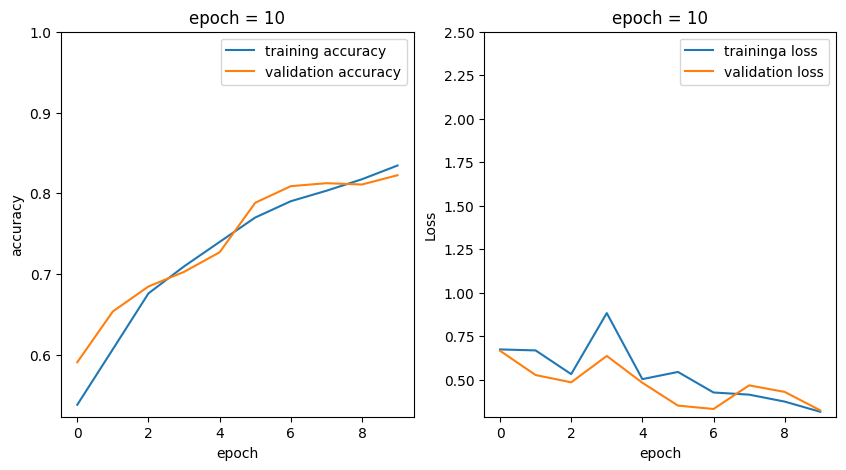

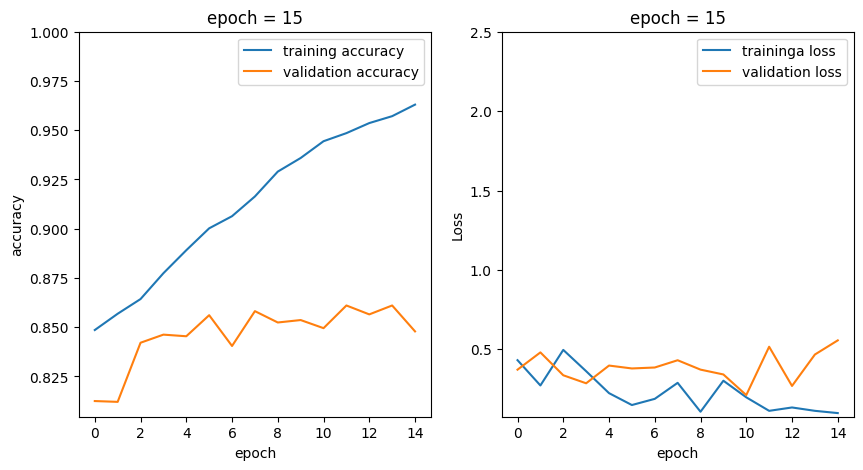

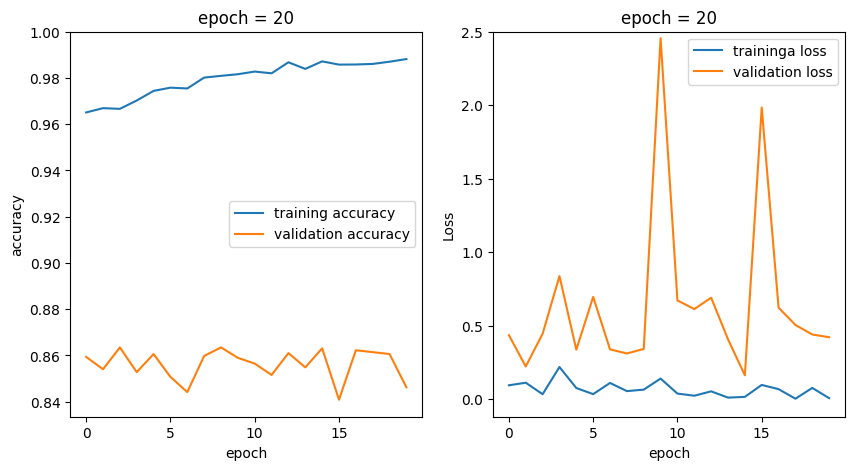

In [ ]:
for idx, t in enumerate(plot_data):
  (train_loss, train_acc, val_loss,val_acc ) = t
 #plt.figure(figsize=(1,1))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(10)
  ax1.plot(train_acc)
  ax1.plot(val_acc)
  ax1.legend(['training accuracy', 'validation accuracy'])
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.set_title('epoch = ' + str(epochs[idx]) )
  ax1.set_ybound(None, 1)

  ax2.plot(train_loss)
  ax2.plot(val_loss)
  ax2.legend(['traininga loss', 'validation loss'])
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('Loss')
  ax2.set_title('epoch = ' + str(epochs[idx]) )
  ax2.set_ybound(None, 2.5)

  plt.show()

Let's try to improve the quality of recognition, using the method of transfer lerning.

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2

1. Build and fit Transfer Learning model using pre-trained VGG16-model weights.
2. Evaluate accuracy on test data for p.1 and p.2
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)
4. Check the performance of your model with the custom image of cat or dog (so the model will tell which class this image belongs to). Develop the function for the inference of the best algorithm.

In [ ]:
# First, download the weights of the VGG16 network trained on the ImageNet dataset:

def make_new_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 1), nn.Sigmoid())

    # Move to gpu and parallelize

    model = model.to(device)

    model.train()
    return model

We construct our model of "transfer learning" by adding two fully connected layers to VGG16

In [ ]:
# add layers to VGG16:
model_2 = make_new_model('vgg16')
summary(model_2, input_size=(64, 3, 224, 224), device='cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 1]                   --
├─Sequential: 1-1                        [64, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [64, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [64, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [64, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [64, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [64, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [64, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [64, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [64, 256, 56, 56]   

In [ ]:
# We also use the generator to train the model (similar to the fit method)
# Without using a GPU, learning 1 epoch of such a network will take about an hour. Plan your time =)
# If you have access to a GPU, you can try 10-12 epochs - the quality should increase even more.

In [ ]:
print(model_2.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=1, bias=True)
  (4): Sigmoid()
)


In [ ]:
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

In [ ]:
epochs = [5]
plot_data_2 = []

for idx, num_epoch in enumerate(epochs):
  print('-------------------------------- set ', idx, '= ',num_epoch,' epochs ---------------------------------------')
  t = model_train(model_2, optimizer_2, num_epoch)
  plot_data_2.append(t)
  print()
  print()

-------------------------------- set  0 =  5  epochs ---------------------------------------


100%|██████████| 312/312 [00:21<00:00, 14.69it/s]


Epoch: 0 	| Train loss: 0.188 	| Test loss: 0.192 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 312/312 [00:21<00:00, 14.56it/s]


Epoch: 1 	| Train loss: 0.168 	| Test loss: 0.158 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 312/312 [00:21<00:00, 14.35it/s]


Epoch: 2 	| Train loss: 0.159 	| Test loss: 0.145 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 312/312 [00:21<00:00, 14.45it/s]


Epoch: 3 	| Train loss: 0.222 	| Test loss: 0.154 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 312/312 [00:21<00:00, 14.36it/s]


Epoch: 4 	| Train loss: 0.223 	| Test loss: 0.317 	| Train acc: 0.91 	| Test acc: 0.91




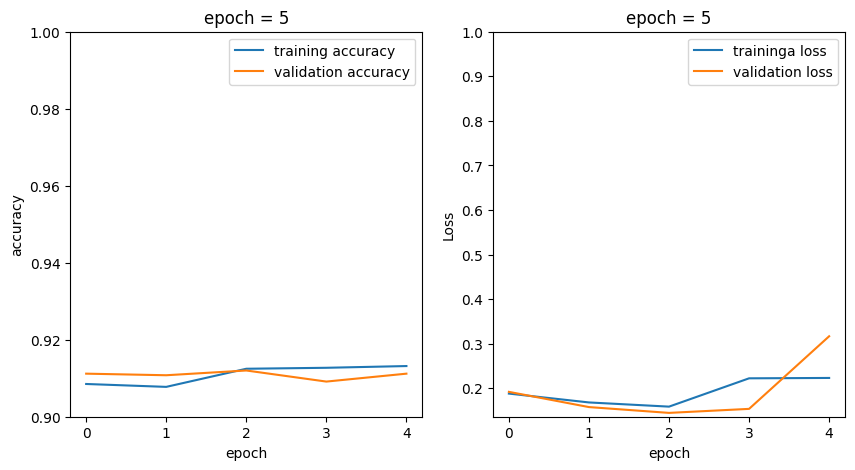

In [ ]:
for idx, t in enumerate(plot_data_2):
  (train_loss, train_acc, val_loss,val_acc ) = t
 #plt.figure(figsize=(1,1))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(5)
  fig.set_figwidth(10)
  ax1.plot(train_acc)
  ax1.plot(val_acc)
  ax1.legend(['training accuracy', 'validation accuracy'])
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('accuracy')
  ax1.set_title('epoch = ' + str(epochs[idx]) )
  ax1.set_ybound(0.9, 1)

  ax2.plot(train_loss)
  ax2.plot(val_loss)
  ax2.legend(['traininga loss', 'validation loss'])
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('Loss')
  ax2.set_title('epoch = ' + str(epochs[idx]) )
  ax2.set_ybound(None, 1)

  plt.show()

# Save and Showcase how good is your model

In [ ]:
def visiualise_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

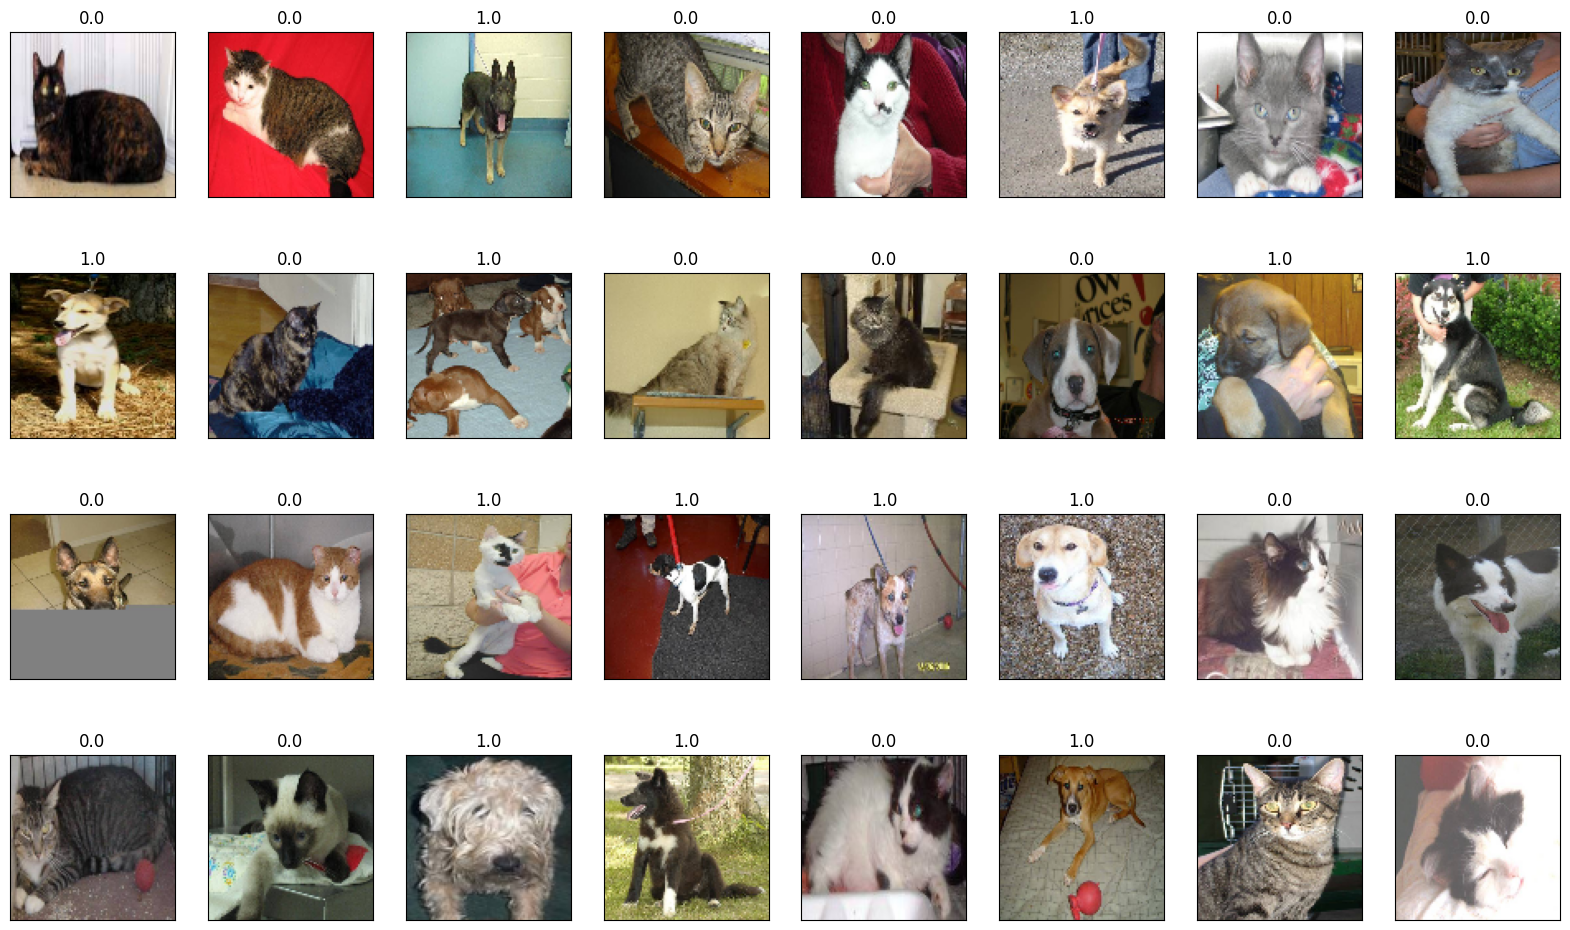

In [ ]:
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

preds_test = model_2(img_test.to(device))
img_test_dim_rot = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

visiualise_images(img_test_dim_rot, rounded_preds, 0)
